In [1]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

%cd "/drive/MyDrive/GitHub Uploads"

Mounted at /drive
/drive/MyDrive/GitHub Uploads


MAB Design

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
#creating dummy data
np.random.seed(42)
#Read the code from Assignment 2 named 'test.csv'
df = pd.read_csv('test.csv', index_col=0)


In [5]:
conditions = {
    "Standard Visual + No Sound": (df["F_Standard Visual"] == True) & (df["No Winning Sound"] == True),
    "Standard Visual + Sound": (df["F_Standard Visual"] == True) & (df["Winning Sound"] == True),
    "Enhanced Visual + No Sound": (df["F_Enhanced Visual"] == True) & (df["No Winning Sound"] == True),
    "Enhanced Visual + Sound": (df["F_Enhanced Visual"] == True) & (df["Winning Sound"] == True),
}

for label, condition in conditions.items():
    print(f"{label}: {condition.sum()} players")

    # Calculate total players and average playtime for each condition
results = []

for label, condition in conditions.items():
    subset = df[condition]  # Filter DataFrame based on the condition
    total_players = condition.sum()  # Count of players in this condition
    avg_playtime = subset["Factorial Playtime"].mean() if total_players > 0 else 0  # Calculate mean playtime
    total_playtime = subset["Factorial Playtime"].sum() if total_players > 0 else 0  # Calculate total playtime
    total_playtime = (total_playtime/3600).round(2)

    results.append([label, total_players, avg_playtime, total_playtime])

# Create DataFrame with results
result_df = pd.DataFrame(results, columns=["Version", "Total Players", "Average Playtime", "Total Playtime (hrs)"])
result_df


Standard Visual + No Sound: 42 players
Standard Visual + Sound: 39 players
Enhanced Visual + No Sound: 37 players
Enhanced Visual + Sound: 42 players


,Version,Total Players,Average Playtime,Total Playtime (hrs)
0,Standard Visual + No Sound,42,1201.190476,14.01
1,Standard Visual + Sound,39,2999.487179,32.49
2,Enhanced Visual + No Sound,37,3002.702703,30.86
3,Enhanced Visual + Sound,42,5999.523810,69.99


Thompson Sampling

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define true average playtime (in seconds) for each variant
true_playtimes = {}
for label, condition in conditions.items():
    subset = df[condition]  # Filter DataFrame based on condition
    total_players = condition.sum()  # Count players in condition
    avg_playtime = subset["Factorial Playtime"].mean() if total_players > 0 else 0  # Compute mean playtime
    true_playtimes[label] = avg_playtime


# Standard deviation for playtime variability
playtime_std = 60

# Parameters
iterations = 20  # Max iterations
samples_per_iteration = 160  # Total number of allocations per iteration (fixed to 160)
arms = list(true_playtimes.keys())  # Available arms
active_arms = arms.copy()  # Track which arms are still active

# Initialize Beta parameters for Thompson Sampling
alpha = {arm: 1 for arm in arms} #markes successes - increase playtime
beta = {arm: 1 for arm in arms} #markes failutre - decrease playtime

# Tracking structures
playtime_per_iteration = {arm: [] for arm in arms}  # Stores playtime data
allocations = {arm: [] for arm in arms}  # Stores allocation data

# Stopping & elimination rules
allocation_stop_threshold = 152  # Stop if any arm reaches 128 allocations (95% of sample polulation)
elimination_threshold = 16  # Minimum allocations before elimination (10% of population)

# Flag to control early stopping of the entire iteration process
all_arms_stopped = False

# Initialize playtime with average value of 3600 seconds
playtime = {arm: 3600 for arm in arms}

# Store previous allocation history
previous_allocations = {arm: 40 for arm in arms}  # First iteration has 40 for each arm

for iteration in range(iterations):
    print(f"Iteration {iteration + 1} started...")

    # Check if only one arm remains
    if len(active_arms) == 1:
        print(f"Only one arm remains: {active_arms[0]}. Stopping iterations.")
        break

    # Track playtime and allocations per arm
    arm_counts = {arm: 0 for arm in active_arms}
    arm_playtime = {arm: [] for arm in active_arms}

    # Handle first iteration where we allocate exactly 40 plays to each arm
    if iteration == 0:
        allocations_this_iteration = {arm: 40 for arm in active_arms}
    else:
        # Evaluate playtime and identify the worst-performing arm
        if iteration == 1:
            # For the second iteration, use the true playtimes to determine worst arm
            avg_playtimes = {arm: true_playtimes[arm] for arm in active_arms}
        else:
            # For subsequent iterations, use the average playtime from previous iterations
            avg_playtimes = {arm: np.mean(playtime_per_iteration[arm]) if playtime_per_iteration[arm] else 0 for arm in active_arms}

        worst_arm = min(avg_playtimes, key=avg_playtimes.get)

        # Penalize the worst-performing arm by reducing its allocations by half
        penalty = max(1, previous_allocations[worst_arm] // 2)
        allocations_this_iteration = {arm: 0 for arm in active_arms}
        allocations_this_iteration[worst_arm] = penalty

        # Apply elimination rule: if an arm's allocation drops below threshold, mark for elimination
        if penalty < elimination_threshold:
            print(f"Arm {worst_arm} marked for elimination (allocation: {penalty} < threshold: {elimination_threshold})")
            active_arms.remove(worst_arm)
            # If arm is eliminated, redistribute its allocation to remaining arms
            if active_arms:  # Make sure there are still active arms
                samples_to_redistribute = penalty
                allocations_this_iteration[worst_arm] = 0  # Remove allocation from eliminated arm
            else:
                print("No active arms remain. Stopping iterations.")
                break
        else:
            samples_to_redistribute = 0

        # Calculate remaining allocations after penalty
        remaining_allocations = samples_per_iteration - penalty + samples_to_redistribute

        # Get non-penalized arms (excluding any eliminated arms)
        non_penalized_arms = [arm for arm in active_arms if arm != worst_arm] if worst_arm in active_arms else active_arms

        if not non_penalized_arms:
            print("No non-penalized arms remain. Stopping iterations.")
            break

        # Calculate total previous allocations for non-penalized arms
        total_prev_non_penalized = sum(previous_allocations[arm] for arm in non_penalized_arms)

        # Distribute remaining allocations proportionally based on previous allocations
        # Temporarily store allocations as floats to maintain precision
        temp_allocations = {}
        for arm in non_penalized_arms:
            proportion = previous_allocations[arm] / total_prev_non_penalized
            temp_allocations[arm] = remaining_allocations * proportion

        # First, allocate the integer portions
        for arm in non_penalized_arms:
            allocations_this_iteration[arm] = int(temp_allocations[arm])

        # Calculate how many allocations are left after integer division
        allocated_so_far = sum(allocations_this_iteration.values())
        remaining = samples_per_iteration - allocated_so_far

        # Distribute remaining allocations based on the fractional parts
        fractional_parts = {arm: temp_allocations[arm] - int(temp_allocations[arm]) for arm in non_penalized_arms}
        arms_by_fraction = sorted(non_penalized_arms, key=lambda a: fractional_parts[a], reverse=True)

        for i in range(remaining):
            allocations_this_iteration[arms_by_fraction[i % len(arms_by_fraction)]] += 1

    # Make sure all arms (active and inactive) have an allocation entry for this iteration
    for arm in arms:
        if arm not in allocations_this_iteration:
            allocations_this_iteration[arm] = 0

    # Now we simulate playtime based on the adjusted allocations
    for arm in active_arms:
        # For each allocation, adjust the playtime based on Beta parameters
        for _ in range(allocations_this_iteration[arm]):
            playtime_change = np.random.normal(0, playtime_std)  # Random playtime change, drawn from a normal distribution

            # Adjust the playtime by sampled probability * playtime change
            sampled_prob = np.random.beta(alpha[arm], beta[arm])
            if np.random.random() < sampled_prob:
                # Playtime increase
                playtime[arm] += playtime_change
            else:
                # Playtime decrease
                playtime[arm] -= playtime_change

            # Ensure that playtime does not go below zero
            playtime[arm] = max(playtime[arm], 0)

            arm_playtime[arm].append(playtime[arm])
            arm_counts[arm] += 1

    # Store playtime and allocations for all arms (including eliminated ones)
    for arm in arms:
        if arm in active_arms and arm_playtime[arm]:
            avg_playtime = np.mean(arm_playtime[arm])
        else:
            avg_playtime = np.nan  # Use NaN for eliminated arms

        playtime_per_iteration[arm].append(avg_playtime)
        allocations[arm].append(allocations_this_iteration[arm])

    # Update previous allocations for the next iteration
    previous_allocations = allocations_this_iteration.copy()

    # Print summary for the current iteration with improved formatting
    print(f"\n{'='*50}")
    print(f"Summary for Iteration {iteration + 1}")
    print(f"{'='*50}")

    for arm in arms:
        # Fetch the average playtime for the current arm in this iteration
        avg_playtime = playtime_per_iteration[arm][-1]

        # Check if the arm is still active; otherwise, use 0 for allocations
        total_allocations = allocations_this_iteration.get(arm, 0) if arm in active_arms else 0

        # Display the results with a clean, structured format
        print(f"\nVariant: {arm}")
        if pd.notna(avg_playtime):  # Display average playtime if valid
            print(f"    Average Playtime: {avg_playtime:.2f} seconds")
        else:
            print(f"    Average Playtime: N/A (Arm Eliminated or No Data)")

        print(f"    Allocations: {total_allocations}")

    print(f"\n{'='*50}\n")


    # Check if any arm should be stopped due to excessive allocations
    for arm in active_arms:
        if allocations[arm][-1] >= allocation_stop_threshold:
            print(f"Stopping early: arm {arm} reached {allocation_stop_threshold} allocations.")
            all_arms_stopped = True
            break
    if all_arms_stopped:
        break  # Stop the iteration early if all arms are either stopped or eliminated



# Ensure all arms have data for the same number of iterations by padding shorter lists with NaNs
max_length = max(len(playtime_per_iteration[arm]) for arm in arms)
for arm in playtime_per_iteration:
    while len(playtime_per_iteration[arm]) < max_length:
        playtime_per_iteration[arm].append(np.nan)  # Padding with NaN for missing data

# Convert playtime tracking to DataFrame for visualization
playtime_df = pd.DataFrame(playtime_per_iteration)


Iteration 1 started...

Summary for Iteration 1

Variant: Standard Visual + No Sound
    Average Playtime: 3652.94 seconds
    Allocations: 40

Variant: Standard Visual + Sound
    Average Playtime: 3611.32 seconds
    Allocations: 40

Variant: Enhanced Visual + No Sound
    Average Playtime: 3437.77 seconds
    Allocations: 40

Variant: Enhanced Visual + Sound
    Average Playtime: 3551.50 seconds
    Allocations: 40


Iteration 2 started...

Summary for Iteration 2

Variant: Standard Visual + No Sound
    Average Playtime: 3558.48 seconds
    Allocations: 20

Variant: Standard Visual + Sound
    Average Playtime: 4182.96 seconds
    Allocations: 47

Variant: Enhanced Visual + No Sound
    Average Playtime: 3639.20 seconds
    Allocations: 47

Variant: Enhanced Visual + Sound
    Average Playtime: 3272.97 seconds
    Allocations: 46


Iteration 3 started...

Summary for Iteration 3

Variant: Standard Visual + No Sound
    Average Playtime: 3528.65 seconds
    Allocations: 24

Variant:

Create MAB Plot

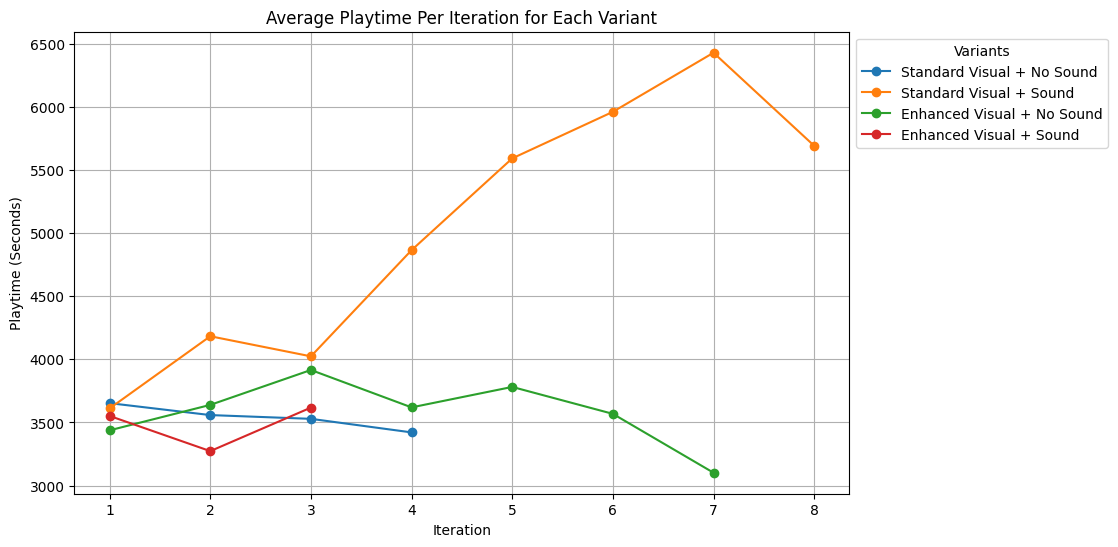

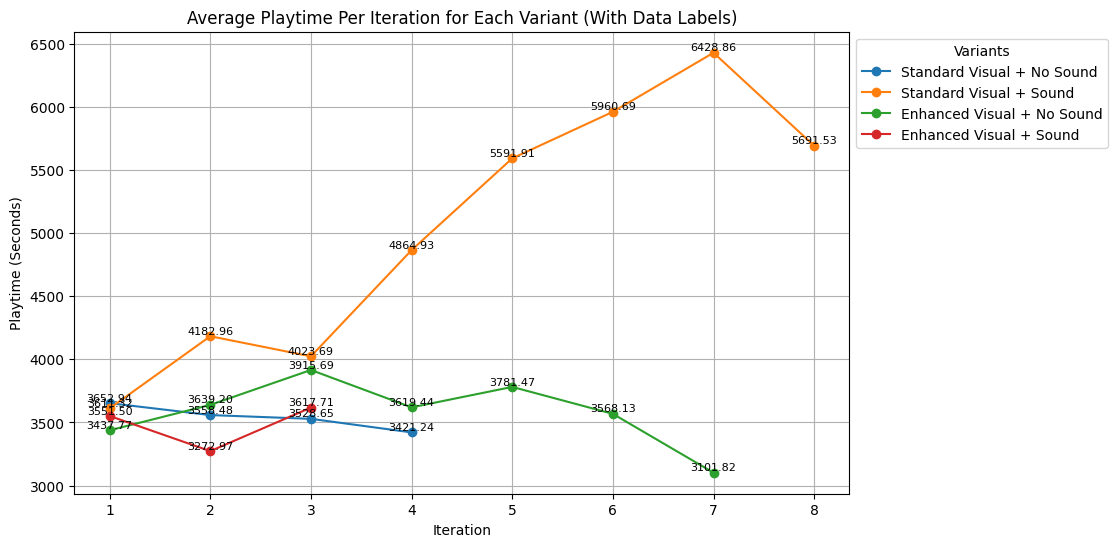


Allocation of Plays Per Iteration:
Iteration                     1    2    3    4    5    6    7    8
Standard Visual + No Sound   40   20   24   28    0    0    0    0
Standard Visual + Sound      40   47   57   67   81  121  141  160
Enhanced Visual + No Sound   40   47   56   65   79   39   19    0
Enhanced Visual + Sound      40   46   23    0    0    0    0    0
Total                       160  160  160  160  160  160  160  160


In [7]:
#Plot: Average Playtime Per Iteration
plt.figure(figsize=(10, 6))
for arm in playtime_df.columns:
    valid_data = playtime_df[arm].dropna()
    if not valid_data.empty:
        x_values = range(1, len(valid_data) + 1)
        y_values = valid_data

        # Plotting the line graph
        plt.plot(x_values, y_values, marker='o', label=arm)

#Visualize the changes
plt.title("Average Playtime Per Iteration for Each Variant")
plt.xlabel("Iteration")
plt.ylabel("Playtime (Seconds)")
plt.xticks(range(1, max_length + 1))
plt.legend(title="Variants", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

#Visulization with data labels:
# Plot: Average Playtime Per Iteration
plt.figure(figsize=(10, 6))
for arm in playtime_df.columns:
    valid_data = playtime_df[arm].dropna()
    if not valid_data.empty:
        x_values = range(1, len(valid_data) + 1)
        y_values = valid_data

        # Plotting the line graph
        plt.plot(x_values, y_values, marker='o', label=arm)

        # Adding values on each data point
        for x, y in zip(x_values, y_values):
            plt.text(x, y, f'{y:.2f}', fontsize=8, ha='center', va='bottom')  # Adjust fontsize and position as needed

plt.title("Average Playtime Per Iteration for Each Variant (With Data Labels)")
plt.xlabel("Iteration")
plt.ylabel("Playtime (Seconds)")
plt.xticks(range(1, max_length + 1))
plt.legend(title="Variants", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


# Convert allocation tracking to DataFrame
allocation_df = pd.DataFrame(allocations)
allocation_df.index = allocation_df.index + 1  # Adjust index to match iteration number
allocation_df.index.name = 'Iteration'
allocation_df = allocation_df.T  # Transpose to make iterations x-axis
allocation_df.loc['Total'] = allocation_df.sum()  # Add total row

print("\nAllocation of Plays Per Iteration:")
print(allocation_df)